In [51]:
import spectral
import pysptools
from spectral import *
from matplotlib import pyplot as plt
import numpy as np


Current data is shaped: (1250, 100, 514)


Text(0, 0.5, 'Calibrated reflectance')

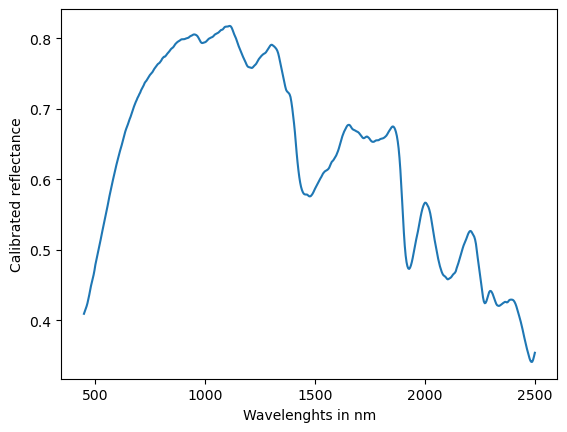

In [282]:
header = envi.read_envi_header('spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.hdr')
# img = open_image('spectra/JA0464_18423_0001_20190207135542_00.procProf3d.hdr')
                 # image = 'spectra/JA0464_18423_0001_20190207135542_00.procProf3d.bin')
curr_data = envi.open('spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.hdr', image = 'spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.bin')

curr_data_array = curr_data.asarray()
print(f"Current data is shaped: {curr_data_array.shape}")

# Let's get the wavelengths in a format we can use
wav_list = [val[0:-2] for val in header['band names']]
wav_array = np.asarray(wav_list).astype(float)

# and the units
wav_unit = header['wavelength units']
n_bands = header['bands']

# Set the pixel we want for now

curr_x = 10
curr_y = 50

curr_pixel = curr_data_array[curr_x, curr_y, :]
plt.plot(wav_array, curr_pixel)
plt.xlabel('Wavelenghts in ' + wav_unit)
plt.ylabel('Calibrated reflectance') 



/tmp/ipykernel_28701/3520652215.py:24: RuntimeWarning: invalid value encountered in log
  plt.plot(wav_array, np.log((curr_pixel - np.polyval(coefficients, wav_array))))


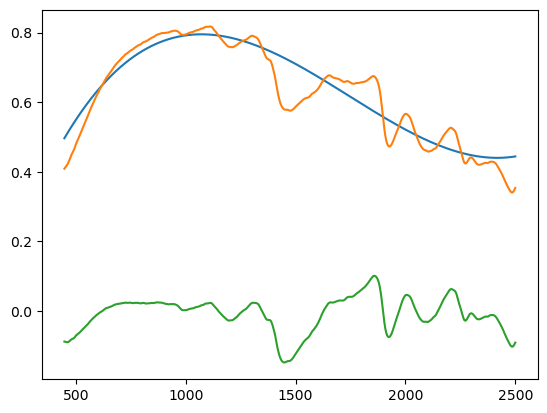

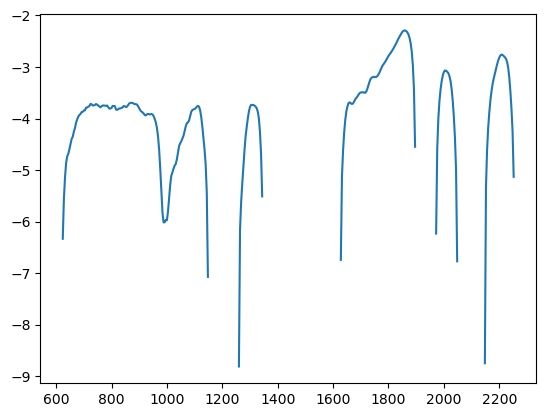

In [283]:
import numpy as np
from scipy.optimize import curve_fit

def fit_continuum(wavelengths, intensities, degree, epsilon=1e-6):
    # Define the polynomial function
    def continuum(wavelength, *coefficients):
        return np.polyval(coefficients, wavelength)

    # Define the weights
    weights = 1 / (intensities + epsilon)

    # Fit the continuum to the spectrum
    coefficients, _ = curve_fit(continuum, wavelengths, intensities, sigma=weights, p0=np.ones(degree + 1))

    return coefficients

coefficients = fit_continuum(wav_array, curr_pixel, 3)

plt.plot(wav_array, (np.polyval(coefficients, wav_array)))
plt.plot(wav_array, (curr_pixel))
plt.plot(wav_array,  (curr_pixel - np.polyval(coefficients, wav_array)))

plt.figure()
plt.plot(wav_array, np.log((curr_pixel - np.polyval(coefficients, wav_array))))

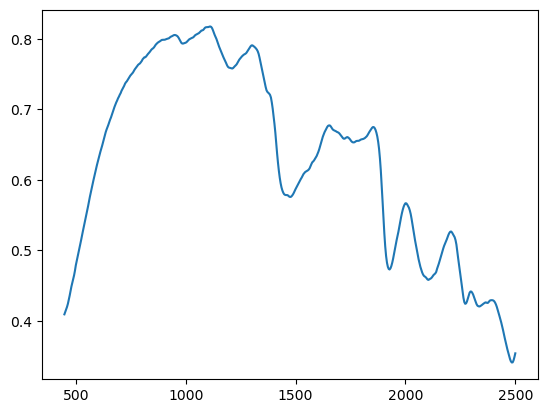

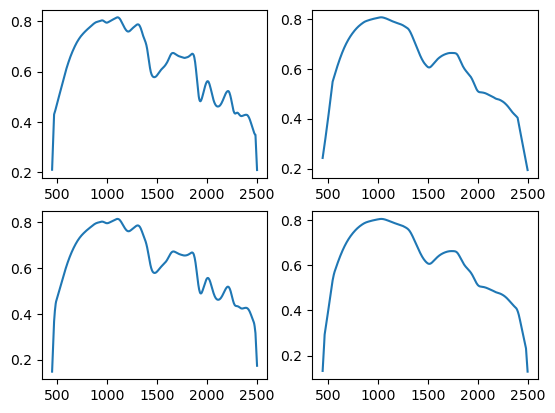

In [284]:
from scipy import signal, interpolate, stats

def boxcar_filtering(input_spectrum, filter_size):
    """
    Apply boxcar filter on the input spectrum.
    """
    box = signal.boxcar(filter_size)
    filtered_spectrum = signal.convolve(input_spectrum, box, mode='same') / filter_size
    return filtered_spectrum

b1 = boxcar_filtering(curr_pixel,
                      int(0.02 * len(curr_pixel)))
b2 = boxcar_filtering(curr_pixel,
                      int(0.1 * len(curr_pixel)))

plt.plot(wav_array, (curr_pixel))
plt.figure()
plt.subplot(2,2,1)
plt.plot(wav_array, (b1))
plt.subplot(2,2,2)
plt.plot(wav_array, (b2))

b3 = boxcar_filtering(b1,
                      int(0.02 * len(b1)))

b4 = boxcar_filtering(b2,
                      int(0.02 * len(b2)))

plt.subplot(2,2,3)
plt.plot(wav_array, (b3))
plt.subplot(2,2,4)
plt.plot(wav_array, (b4))

Gen_spectrum=Generic_1nm_Interpolation(Input_Spectrum, Method=’Cubic Splines’)

First_filt_step=Filter_Boxcar(Gen_Spectrum, boxcar_length=’10% of Gen_spectrum’)

Second_filt_step=Filter_Boxcar(First_filt_step, boxcar_length=’10% of Gen_spectrum’)

Third_filt_step=Filter_Boxcar(Gen_Spectrum, boxcar_length=’2% of Gen_spectrum’) 

Fourth_filt_step=Filter_Boxcar(Third_filt_step, boxcar_length=’2% of Gen_spectrum’)

Aux1=Stdev(Second_filt_step- First_filt_step)

Aux2=Stdev(Fourth_filt_step- Third_filt_step)

If Aux1>=Aux2:

Aux3= First_filt_step/Second_filt_step 

Else:

Aux3= Third_filt_step/Fourth_filt_step

These minima serve as nodes of a lower hull that is constructed by linear interpolation between the absorption minima. This lower hull is now subtracted from the input spectrum, setting the preliminary minima to zero. The maximum in each non-zero segment is found and added to a list that contains the nodes of an upper hull curve of the spectrum. Linear interpolation is carried out between these nodes to yield a preliminary upper hull.


The points from this preliminary hull are then subtracted from the input spectrum to check for zero crossings between the two point sets. More node points are added to the preliminary hull at the zero-crossing points. The iteration stops if no more maxima can be added to the continuum node list. The final node list is then used to construct the final geometric hull.


Peaks=Extract_Absorption_Peaks(Aux3) 

Peak_Indices=Get_Indices(Absorption_Peaks) 

Lower_Hull=Interpolate_Linear(Gen_Spectrum,Peak_Indices) 

Segments=(Gen_Spectrum-Lower_Hull)

For each Segment in Segments:

Nodes=Get_Indices_of_Maximum(Segment) 

Preliminary_Hull=Interpolate_Linear(Input_Spectrum,Nodes) 

Hull=Iterate_over_Segments_unitl_Final_Hull_is_Found(Nodes, Gen_Spectrum) 

Feature_Depth_Absolute, Feature_Depth_Relative =Hull_Removal(Hull,Gen_Spectrum)

Return (Hull, Feature_Depth_Absolute, Feature_Depth_Relative)

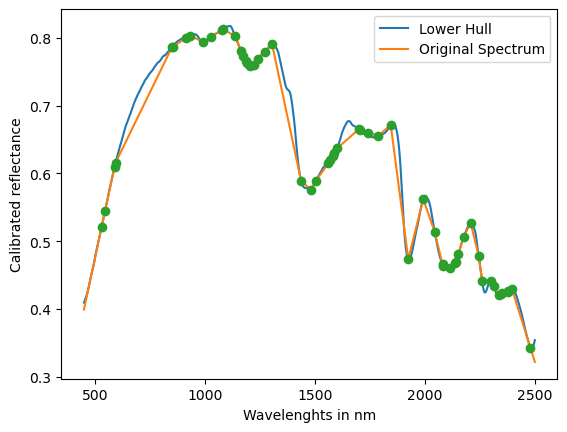

In [285]:
from scipy.interpolate import interp1d

# Extract absorption peaks
def extract_absorption_peaks(spectrum):
    # Assuming the spectrum is a 1D numpy array
    # We find the indices where the derivative changes sign - these are the peaks
    peaks = np.where(np.diff(np.sign(np.gradient(spectrum))))[0]
    return peaks

peaks = extract_absorption_peaks(aux3)

# Get indices of absorption peaks
# In this case, the peaks variable already contains the indices, so we can just rename it
peak_indices = peaks

# Interpolate linearly to get the lower hull
def interpolate_linear(spectrum, indices):
    # Create an interpolation function based on the given indices
    interp_func = interp1d(indices,
                           spectrum[indices],
                           fill_value="extrapolate")
    # Apply the interpolation function to the entire range of indices
    lower_hull = interp_func(np.arange(len(spectrum)))
    return lower_hull

lower_hull = interpolate_linear(curr_pixel,
                                peak_indices)
# Plot the lower hull as currently found
plt.plot(wav_array, curr_pixel)
plt.plot(wav_array, lower_hull)
plt.xlabel('Wavelenghts in ' + wav_unit)
plt.ylabel('Calibrated reflectance') 
plt.legend(['Lower Hull', 'Original Spectrum', 'Nodes'])

plt.plot(wav_array[peaks], curr_pixel[peaks], 'o')


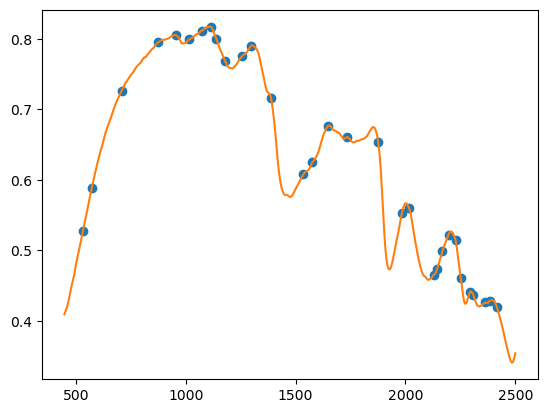

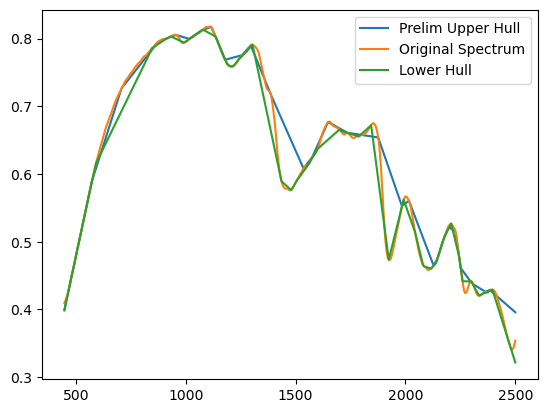

In [286]:
# The maximum in each non-zero segment is found
# and added to a list that contains the nodes of an upper hull curve of the spectrum.

# Make a set of segments from the interpolation
lower_hull_diff = curr_pixel - lower_hull

# seg_list = []
# for i in range(peaks.shape[0] -1):
#     curr_start = peaks[i]
#     curr_end = peaks[i+1]    
#     seg_list.append(np.argmax(lower_hull_diff[curr_start:curr_end]) + peaks[i])
    
# seg_array = np.asarray(seg_list)

def max_in_non_zero_segments(array, indices):
    """
    This function finds the maximum in each non-zero segment of an array.
    Segments are defined as ranges between two indices.
    
    Parameters:
    array (numpy array): The array to find the maximum in each non-zero segment.
    indices (numpy array): The indices defining the segments.

    Returns:
    list: A list of tuples, where each tuple contains the index of the maximum value and the maximum value itself for each non-zero segment.
    """
    
    max_indices = []
    
    # Iterate over the indices
    for i in range(len(indices) - 1):
        # Define the segment
        segment = array[indices[i]:indices[i+1]]
        
        # Ignore zero segments
        if np.count_nonzero(segment) == 0:
            continue
        
        # Find the maximum value in the segment
        max_value = np.max(segment)
        
        if max_value == 0:
            continue
        
        # Find the index of the maximum value in the segment
        max_index = np.argmax(segment) + indices[i]
        
        max_indices.append(max_index)
    
    return np.asarray(max_indices)

seg_array = max_in_non_zero_segments(lower_hull_diff, peaks)


 # Linear interpolation is carried out between these nodes to yield a preliminary upper hull.

upper_hull = interpolate_linear(curr_pixel, seg_array)
plt.plot(wav_array[seg_array], curr_pixel[seg_array], 'o')
plt.plot(wav_array, curr_pixel)


# Plot the upper hull as currently found
plt.figure()
plt.plot(wav_array, upper_hull)
plt.plot(wav_array, curr_pixel)
plt.plot(wav_array, lower_hull)

plt.legend(['Prelim Upper Hull', 'Original Spectrum', "Lower Hull"])

prelim_indices = seg_array

The points from this preliminary hull are then subtracted from the input spectrum to check for zero crossings between the two point sets. More node points are added to the preliminary hull at the zero-crossing points. The iteration stops if no more maxima can be added to the continuum node list. The final node list is then used to construct the final geometric hull.

Current iteration 10
Current iteration 20
Current iteration 30
Current iteration 40
Current iteration 50
Current iteration 60
Current iteration 70
Current iteration 80
Current iteration 90
Current iteration 100
Current iteration 110
Current iteration 120
Current iteration 130
Current iteration 140
Current iteration 150
Current iteration 160
Current iteration 170
Current iteration 180
Current iteration 190
Current iteration 200
Current iteration 210
Current iteration 220
Current iteration 230
Current iteration 240
Current iteration 250
Current iteration 260
Current iteration 270
Current iteration 280
Current iteration 290
Current iteration 300
Current iteration 310
Current iteration 320
Current iteration 330
Current iteration 340
Current iteration 350
Current iteration 360
Current iteration 370
Current iteration 380
Current iteration 390
Current iteration 400
Current iteration 410
Current iteration 420
Current iteration 430
Current iteration 440
Current iteration 450
Current iteration 4

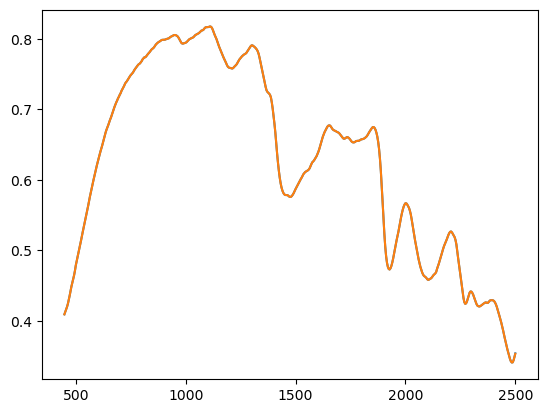

In [288]:
# # Iterate over segments until final hull is found
# # This is a bit vague without more details, but here's a possible interpretation:
# def iterate_over_segments_until_final_hull_is_found(nodes, spectrum):
#     # Start with the preliminary hull
#     hull = preliminary_hull
#     # Iterate until convergence
#     while True:
#         # Update the nodes based on the current hull
#         nodes = get_indices_of_maximum(spectrum - hull)
#         # Update the hull based on the new nodes
#         new_hull = interpolate_linear(spectrum, nodes)
#         # Check for convergence
#         if np.allclose(new_hull, hull):
#             break
#         # Update the hull
#         hull = new_hull
#     return hull

# hull = iterate_over_segments_until_final_hull_is_found(nodes, Aux3)

def check_zero_crossings(point_set1, point_set2):
    """
    This function checks for zero crossings between two point sets.
    A zero crossing occurs when the difference between the two point sets changes sign.
    
    Parameters:
    point_set1 (numpy array): The first point set.
    point_set2 (numpy array): The second point set.

    Returns:
    numpy array: The indices where zero crossings occur.
    """
    
    # Calculate the difference between the two point sets
    difference = point_set1 - point_set2
    
    # Find the indices where the difference changes sign
    zero_crossings = np.where(np.diff(np.sign(difference)))[0]
    
    return zero_crossings

curr_prelim = upper_hull
union_array = seg_array
run_loop = True;
iterations = 0
while run_loop:
    curr_zero_crossings = check_zero_crossings(curr_pixel,
                                               curr_prelim)
    if curr_zero_crossings.shape[0]>0:
        union_array = np.unique(np.sort(np.concatenate((union_array,
                                              curr_zero_crossings))))
        curr_prelim = interpolate_linear(curr_pixel,
                                         union_array)
        iterations +=1 
        if np.mod(iterations, 10) == 0:
            print(f"Current iteration {iterations}")
    if curr_zero_crossings.shape[0] >= curr_pixel.shape[0] or iterations > 1000 :
        run_loop = False
    

# prelim_indices
# curr_zero_crossings = check_zero_crossings(curr_pixel, curr_prelim)

plt.figure()
plt.plot(wav_array, curr_pixel)
plt.plot(wav_array, curr_prelim)

Round 0: 
[ 30  31  61  62 104 105 117 119 125 126 141 142 144 146 154 155 159 165
 166 170 171 173 174 179 180 181 182 202 203 205 208 211 212 227 232 234
 235 272 273 281 282 283 284 285 286 291 299 300 303 323 324 335 336 357
 358 384 385 391 392 430 431 432 433 434 435 443 444 448 449 450 451 461
 462 463 464 477 478 481 492 493]
Round 1: 
[ 29  31  60  62 101 103 105 112 113 114 115 116 117 118 119 124 126 140
 142 143 144 145 146 153 155 158 159 164 166 169 171 172 174 178 182 201
 203 204 205 207 208 210 212 226 227 231 232 233 235 271 273 280 286 290
 291 298 300 302 303 322 324 334 336 356 358 383 385 390 392 429 435 442
 444 447 451 460 464 476 478 480 481 491 493 494 495 496 497 498 499 500
 501 502 503 504 505 506 507 508 509 510 511 512]


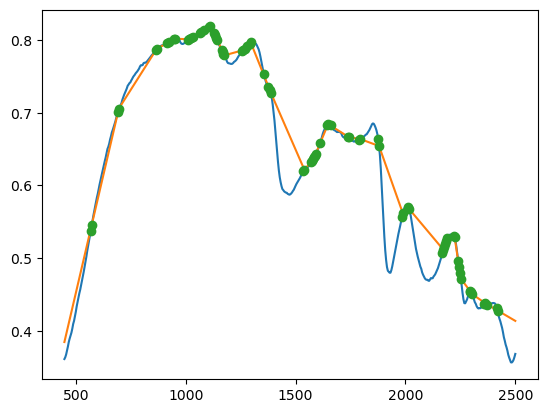

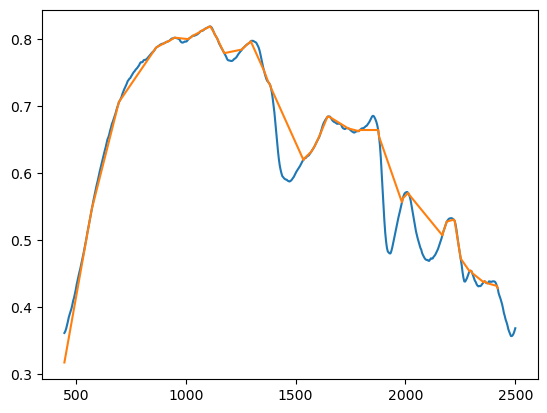

In [259]:
curr_prelim = upper_hull
union_array = seg_array

plt.plot(wav_array, curr_pixel)
plt.plot(wav_array, curr_prelim)
curr_zero_crossings = check_zero_crossings(curr_pixel,
                                               curr_prelim)
print('Round 0: ')
print(curr_zero_crossings)
plt.plot(wav_array[curr_zero_crossings], curr_pixel[curr_zero_crossings], 'o')

if curr_zero_crossings.shape[0]>0:
    union_array = np.sort(np.concatenate((union_array,
                                          curr_zero_crossings)))
    curr_prelim = interpolate_linear(curr_pixel,
                                     union_array)
    
plt.figure()
plt.plot(wav_array, curr_pixel)
plt.plot(wav_array, curr_prelim)

curr_zero_crossings = check_zero_crossings(curr_pixel,
                                           curr_prelim)
print('Round 1: ')
print(curr_zero_crossings)